In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.Dataset

Total de imagens: 16672
Total de classes: 5

classe
Neutrophil    10901
Lymphocyte     3609
Eosinophil     1066
Monocyte        795
Basophil        301
2. Propriedades das imagens
   (amostra de 30 imagens por classe)

Resolucoes únicas encontradas:
 largura  altura
     506     490
     495     494
     489     487
     488     484
     485     485
     480     514
     488     489
     496     493
     494     482
     488     487
     478     489
     497     495
     493     497
     487     486
     484     494
     485     489
     486     485
     497     494
     489     493
     490     485
     485     486
     488     493
     491     490
     490     483
     494     492
     485     487
     575     575
     486     493
     488     486
     493     493
     490     488
     495     495
     501     492
     489     490
     491     497
     488     485
     501     489
     498     487
     487     493
     483     483
     496     491
     496     499
     492

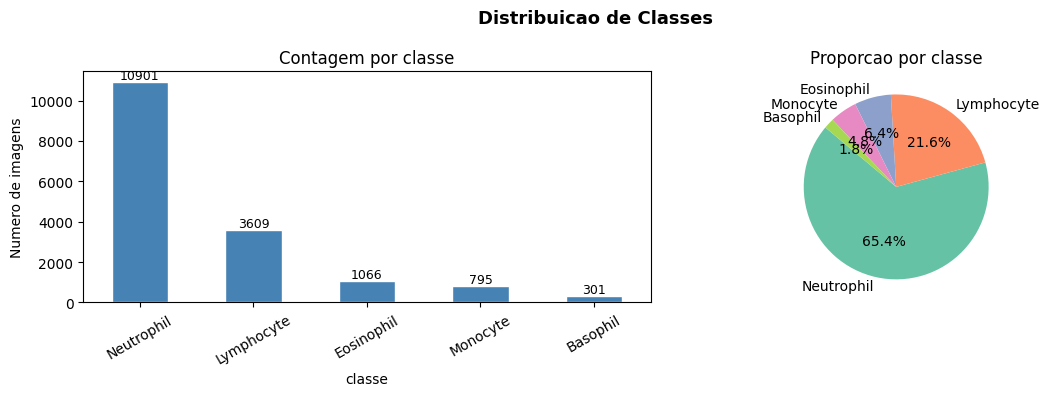

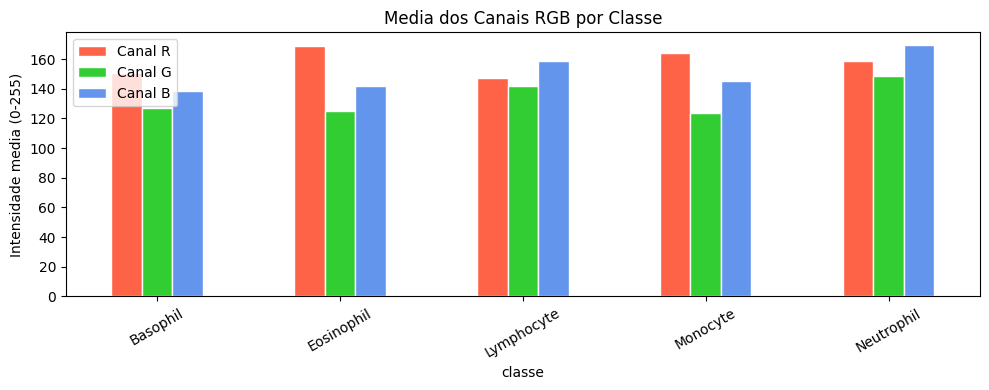

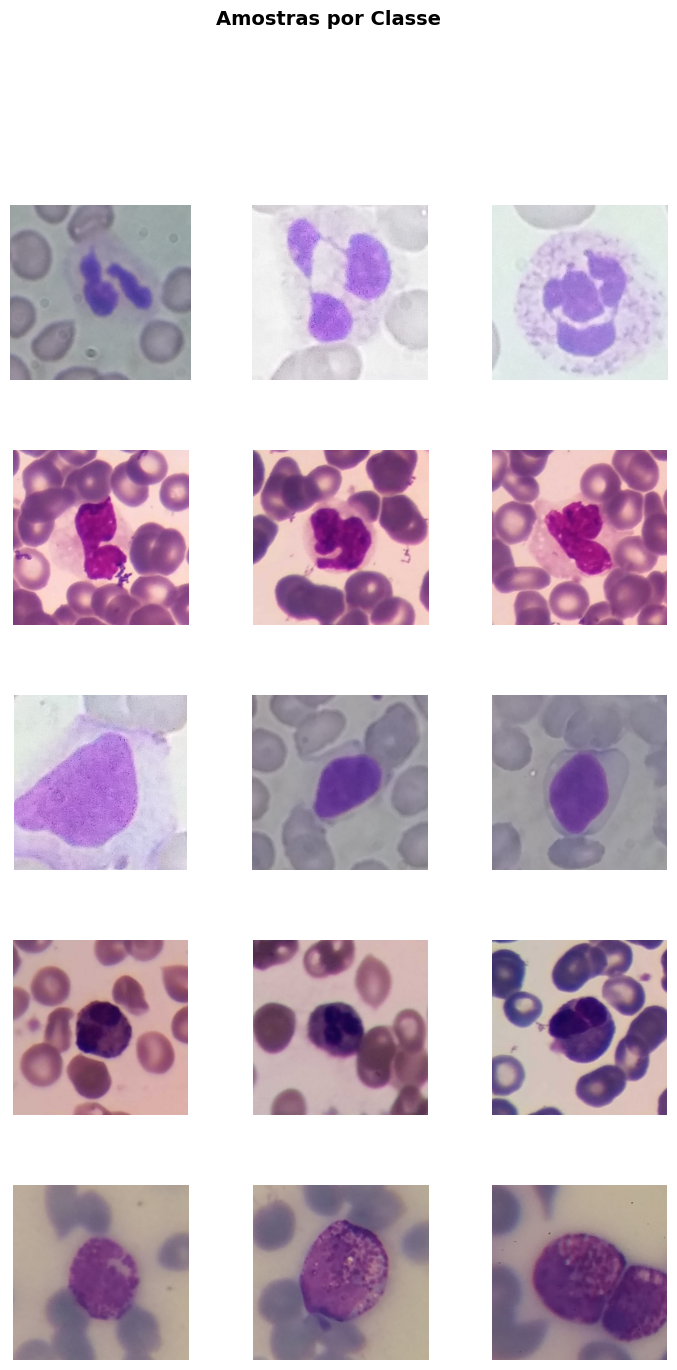

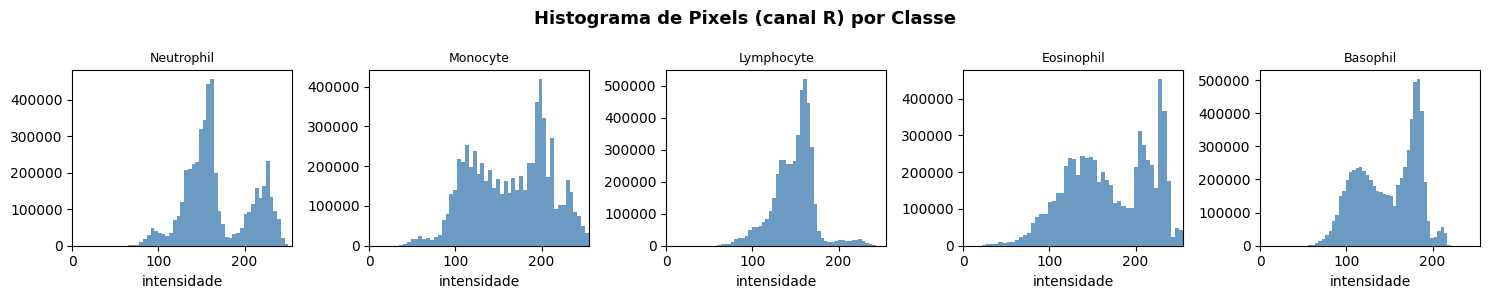

3. RESUMO
Total de imagens  : 16672
Classes           : Neutrophil, Monocyte, Lymphocyte, Eosinophil, Basophil
Resolucao mediana : 575 x 575 px
Balanceamento     : Desbalanceado
  min=301 (Basophil)  max=10901 (Neutrophil)



In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from pathlib import Path


DATASET_DIR = Path('/content/drive/MyDrive/Capstone_project/Dataset/U_net/dataset_crops_wbc')
CLASSES = ["Neutrophil", "Monocyte", "Lymphocyte", "Eosinophil", "Basophil"]
SAMPLE_PER_CLASS = 3       # amostras visuais por classe
MAX_PROPS = 30             # max imagens por classe para calcular propriedades

# 1. Dataset

print("1.Dataset")
records = []
for cls in CLASSES:
    folder = DATASET_DIR / cls
    if not folder.exists():
        print(f"  Pasta nao encontrada: {folder}")
        continue
    images = sorted(folder.glob("*.jpg")) + sorted(folder.glob("*.png"))
    for img_path in images:
        records.append({"classe": cls, "arquivo": img_path.name, "caminho": img_path})

df = pd.DataFrame(records)
print(f"\nTotal de imagens: {len(df)}")
print(f"Total de classes: {df['classe'].nunique()}\n")

contagem = df["classe"].value_counts()
print(contagem.to_string())

# 2. Propriedades das imagens
print("2. Propriedades das imagens")
print(f"   (amostra de {MAX_PROPS} imagens por classe)")

props = []
for cls in CLASSES:
    subset = df[df["classe"] == cls]["caminho"].tolist()
    amostra = subset[:MAX_PROPS]
    for img_path in amostra:
        try:
            img = Image.open(img_path).convert("RGB")
            w, h = img.size
            arr = np.array(img)
            props.append({
                "classe": cls,
                "largura": w,
                "altura": h,
                "mean_r": arr[:, :, 0].mean(),
                "mean_g": arr[:, :, 1].mean(),
                "mean_b": arr[:, :, 2].mean(),
            })
        except Exception as e:
            print(f"  [ERRO] {img_path}: {e}")

df_props = pd.DataFrame(props)

print("\nResolucoes únicas encontradas:")
print(df_props[["largura", "altura"]].drop_duplicates().to_string(index=False))

print("\nMedia dos canais RGB por classe:")
print(df_props.groupby("classe")[["mean_r", "mean_g", "mean_b"]].mean().round(1).to_string())

# 3. Visualizações

# Distribuicao de classes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Distribuicao de Classes", fontsize=13, fontweight="bold")

contagem.plot(kind="bar", ax=axes[0], color="steelblue", edgecolor="white")
axes[0].set_title("Contagem por classe")
axes[0].set_ylabel("Numero de imagens")
axes[0].tick_params(axis="x", rotation=30)
for p in axes[0].patches:
    axes[0].annotate(str(int(p.get_height())),
                     (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha="center", va="bottom", fontsize=9)

axes[1].pie(contagem, labels=contagem.index, autopct="%1.1f%%",
            startangle=140, colors=plt.cm.Set2.colors[:len(contagem)])
axes[1].set_title("Proporcao por classe")

plt.tight_layout()
plt.show()

# Media de canais por classe
fig, ax = plt.subplots(figsize=(10, 4))
canal_por_classe = df_props.groupby("classe")[["mean_r", "mean_g", "mean_b"]].mean()
canal_por_classe.plot(kind="bar", ax=ax,
                      color=["tomato", "limegreen", "cornflowerblue"],
                      edgecolor="white")
ax.set_title("Media dos Canais RGB por Classe")
ax.set_ylabel("Intensidade media (0-255)")
ax.tick_params(axis="x", rotation=30)
ax.legend(["Canal R", "Canal G", "Canal B"])
plt.tight_layout()
plt.show()


# Grade de amostras por classe
n_classes = len(CLASSES)
fig = plt.figure(figsize=(SAMPLE_PER_CLASS * 3, n_classes * 3))
fig.suptitle("Amostras por Classe", fontsize=14, fontweight="bold", y=1.01)
gs = gridspec.GridSpec(n_classes, SAMPLE_PER_CLASS, figure=fig,
                       hspace=0.4, wspace=0.1)

for i, cls in enumerate(CLASSES):
    subset = df[df["classe"] == cls]["caminho"].tolist()
    for j, path in enumerate(subset[:SAMPLE_PER_CLASS]):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(Image.open(path))
        ax.axis("off")
        if j == 0:
            ax.set_ylabel(cls, fontsize=10, fontweight="bold",
                          rotation=0, labelpad=60, va="center")

plt.show()

# Histograma de pixels por classe (amostra de 20 imagens)
fig, axes = plt.subplots(1, n_classes, figsize=(n_classes * 3, 3))
fig.suptitle("Histograma de Pixels (canal R) por Classe", fontsize=13, fontweight="bold")

for ax, cls in zip(axes, CLASSES):
    caminhos = df[df["classe"] == cls]["caminho"].tolist()[:20]
    pixels = np.concatenate([
        np.array(Image.open(p).convert("RGB"))[:, :, 0].flatten()
        for p in caminhos
    ])
    ax.hist(pixels, bins=50, color="steelblue", edgecolor="none", alpha=0.8)
    ax.set_title(cls, fontsize=9)
    ax.set_xlabel("intensidade")
    ax.set_xlim(0, 255)

plt.tight_layout()
plt.show()


print("3. RESUMO")
print(f"Total de imagens  : {len(df)}")
print(f"Classes           : {', '.join(CLASSES)}")
print(f"Resolucao mediana : {int(df_props['largura'].median())} x {int(df_props['altura'].median())} px")
balanceado = contagem.std() < 50
print(f"Balanceamento     : {'Balanceado' if balanceado else 'Desbalanceado'}")
print(f"  min={contagem.min()} ({contagem.idxmin()})  max={contagem.max()} ({contagem.idxmax()})")
print()